<a href="https://colab.research.google.com/github/wilkieolin/VSA-notebooks/blob/main/VSA_Introduction_4_Mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recap

In this series, we've introduced vector symbolic architectures (VSAs) and the operations which allow them to robustly and efficiently represent complex structures such as graphs. However, in all the examples we've explored so far, we've started out by defining our problem in terms of symbols. In other words, we haven't used any 'real-world' data such as images as the input for a vector-symbolic computation. In this tutorial, we'll explore how to accomplish this and how neural networks can play a role in this process. 

# Real-World Computation

In this tutorial, we'll demonstrate a relatively basic example of how neural networks can be integrated with vector-symbolic computation. A common set of images, "Fashion-MNIST," will be used as our real-world dataset. Each example in the set consists of a picture of an article of clothing accompanied by a class identifier (e.g. "T-shirt"). We'll start by loading this dataset using the tensorflow-datasets backend:

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

#disable TF access to the GPU, it's only being used to load the dataset
tf.config.set_visible_devices([], 'GPU')

dataset_name = "fashion_mnist"
batch_size = 128

In [2]:
#function to load the given dataset in three portions: iterator for training, full
# set of images, and full set of labels

def load_dataset(dataset_name: str,
                split: str,
                *,
                is_training: bool,
                batch_size: int,
                repeat: bool = True):

    #load a batched copy of the dataset
    ds = tfds.load(dataset_name, data_dir="~/data", split=split).cache()
    if repeat:
        ds = ds.repeat()
    if is_training:
        ds = ds.shuffle(10 * batch_size, seed=0)
    ds = ds.batch(batch_size)

    #load full copies of the dataset images and labels
    x_full, y_full = tfds.as_numpy(tfds.load(dataset_name, 
                    split=[split], 
                    data_dir="~/data",
                    shuffle_files=True,
                    as_supervised=True,
                    batch_size=-1,
                    with_info=False))[0]

    return iter(tfds.as_numpy(ds)), x_full, y_full

In [3]:
label_map = {0: "T-Shirt",
             1: "Trouser",
             2: "Pullover",
             3: "Dress", 
             4: "Coat",
             5: "Sandal",
             6: "Shirt",
             7: "Sneaker",
             8: "Bag",
             9: "Ankle Boot",
             }

In [4]:
#load an interator over the dataset and a full copy of it
dataset_train, images_full, labels_full = load_dataset(dataset_name, "train", is_training = True, batch_size = batch_size)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/data/fashion_mnist/3.0.1.incompleteCFSMF3/fashion_mnist-train.tfrecord


  0%|          | 0/60000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/data/fashion_mnist/3.0.1.incompleteCFSMF3/fashion_mnist-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/data/fashion_mnist/3.0.1. Subsequent calls will reuse this data.
Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Now that we've loaded our dataset, we can inspect it. Here we have an example image:

Image is of a Pullover


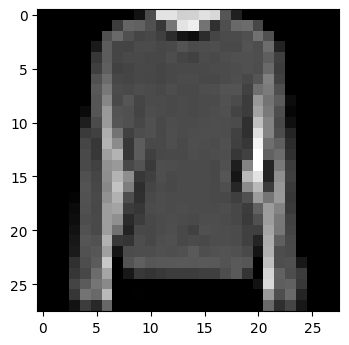

In [60]:
plt.figure(dpi=100)
plt.imshow(images_full[0,:,:,0], cmap="gray")
print("Image is of a " + label_map[labels_full[0]])

This image is encoded as a single frame of 28 x 28 unsigned, 8-bit integers:

In [38]:
print("Image shape is", images_full[0,...].shape, "and has datatype", images_full.dtype)

Image shape is (28, 28, 1) and has datatype uint8


# Vector-Symbolic Classification

One of the most common image processing tasks is *image classification*. Given an image like we have above, the task is to predict what *class* the image belongs to. In this case, given a picture of an article of clothing, we would like to be able to predict what it is: a t-shirt, shoe, etc. While trivial for humans, before the advent of modern neural networks this task remained highly challening for computers. 

There are hundreds of tutorials which will demonstrate how to use a neural network to classify an image, but in this one we will take a slightly different approach. Instead of using a neural network to transform an input image into a set of class predictions, we will use the network to transform the image into a vector-symbol. Each symbol produced from an image will then be compared to a series of symbols representing each class. The class with the highest similarity to the symbol produced from the image is then the predicted class.

In [7]:
# import JAX which will be used as the backend for the neural network and vector-symbols
import jax.numpy as jnp
from jax import random, vmap, jit, nn, grad

# import the VSA functions we've explicitly defined in the previous notebooks
!git clone https://github.com/wilkieolin/FHRR
from FHRR.fhrr_vsa import *

Cloning into 'FHRR'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6 (delta 0), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


In [8]:
#install and import the ML libraries for JAX
!pip install optax==0.0.9
!pip install dm-haiku==0.0.5
import haiku as hk
import optax

     |████████████████████████████████| 118 kB 8.5 MB/s 
     |████████████████████████████████| 65 kB 2.7 MB/s 
     |████████████████████████████████| 287 kB 8.3 MB/s 


First, we'll define a series of symbols which will represent each class of clothing:

In [9]:
key = random.PRNGKey(42)
key, subkey = random.split(key)
#set the dimensionality of the VSA
VSA_dimensionality = 1024
#generate the symbols used to represent each class of clothing
class_codebook = generate_symbols(subkey, len(label_map.keys()), VSA_dimensionality)

#declare a separate instance of each symbol which we can use later
trouser = class_codebook[0:1,:]
pullover = class_codebook[1:2,:]
dress = class_codebook[2:3,:]
coat = class_codebook[4:5,:]
sandal = class_codebook[5:6,:]
shirt = class_codebook[6:7,:]
sneaker = class_codebook[7:8,:]
bag = class_codebook[8:9,:]
ankle_boot = class_codebook[9:,:]

The task the neural network now needs to accomplish is given an input image - a series of 784 8-bit integers - it needs to map it into a vector-symbol. In this case, as we're still using the Fourier Holographic Reduced Representation, this will be a series of angles - by default, we'll use 1024 angles in the series (defined by `VSA_dimensionality` above).


We'll use a simple neural network with 3 layers to accomplish this mapping between domains. It consists of 12 3x3 convolutional kernels, a 100-neuron fully-connected layer, and a 1024-neuron output. We apply a *softsign* to the final layer, producing an output which matches the domain of our vector-symbols ([-1, 1]). 

In [10]:
#convert 8-bit [0,255] images to [0,1] floating points
def scale_mnist(images):
    return jnp.divide(images, 255)

#use a simple convolutional network
def network_fn(images):
    mlp = hk.Sequential([
                        scale_mnist,
                        hk.Conv2D(12, (3,3)),
                        nn.relu,
                        hk.Flatten(),
                         
                        hk.Linear(100),
                        nn.relu,
                         
                        hk.Linear(VSA_dimensionality),
                        nn.soft_sign,
    ])

    return mlp(images)

Now, we'll use [Haiku](https://dm-haiku.readthedocs.io/en/latest/index.html) to produce a function we can call to execute this network and initialize a set of parameters for it. In contrast to PyTorch and Tensorflow, here the network is purely functional instead of a stateful object, which leads to some differences in how we'll train and execute it below. 

In [11]:
#return a pure function from the network
network_full = hk.transform(network_fn)
#exclude the rng parameter from the function since it's not used in the model
network = hk.without_apply_rng(network_full)

#generate a new random key
key, subkey = random.split(key)
#use it to initialize the parameters to be used with the network function
params = network.init(subkey, images_full[0:batch_size,...])

Now, we can test our network with the initial, random parameters and inspect the outputs. Just as we designed it, each input image leads to an output which can be considered a vector-symbol. For each output, we can compare it to the symbols we defined and see if they have any similarity:

In [16]:
#produce a series of example outputs from the network
symbols_0 = network.apply(params, images_full[0:batch_size,...])

initial_similarity = similarity_outer(symbols_0, class_codebook)

In [61]:
def plot_similarity(image_symbols, 
                    label_symbols = class_codebook, 
                    classes = list(label_map.values())):
  
    s = similarity_outer(image_symbols, class_codebook)
    
    plt.figure(dpi=100)
    plt.pcolor(s, vmin=-1, vmax=1)
    plt.colorbar()
    plt.xlabel("Class Symbol")
    plt.xticks(jnp.arange(0,10)+0.5, list(label_map.values()), rotation=90)
    plt.ylabel("Input Image")
    plt.title("Similarity Between Image Symbols and Label Symbols")

As we can see below, none of the symbols produced from an image by applying the neural network are similar to the symbols in the codebook which define each of the clothing classes. This is what we'd expect, given that random symbols in our VSA are dissimilar, and our neural network has been initialized with random parameters. 

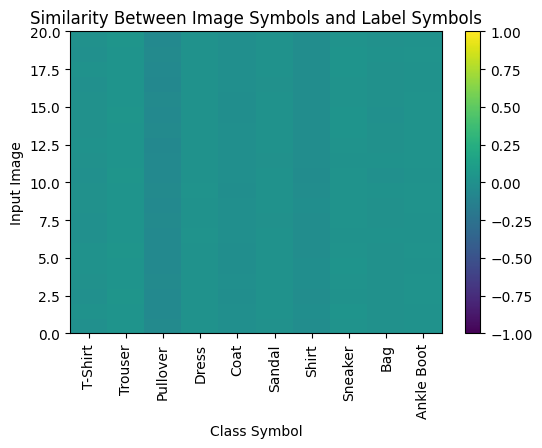

In [62]:
plot_similarity(symbols_0[0:20,...])

Text(0.5, 1.0, 'Similarity Between Image Symbols and Label Symbols')

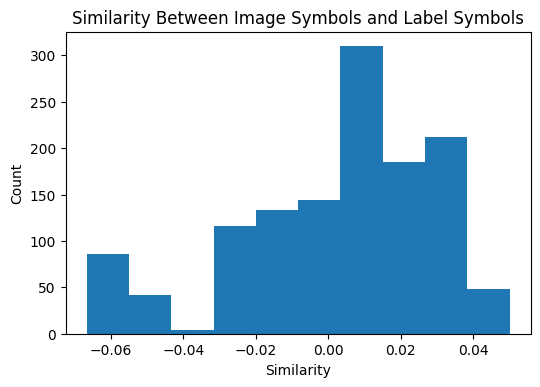

In [63]:
plt.figure(dpi=100)
plt.hist(jnp.ravel(initial_similarity))
plt.xlabel("Similarity")
plt.ylabel("Count")
plt.title("Similarity Between Image Symbols and Label Symbols")

# Training 

Now, our task is to figure out how to train the neural network to produce the mapping we want: given an input image of a T-shirt, we want the neural network to produce a symbol which is highly similar to the `shirt` symbol. To do this, we'll define our loss function for the network:

In [36]:
#Calculate the similarity between each symbol and its matching class symbol, then
# invert it and add to one to calculate loss

@jit
def similarity_loss(symbols, labels, class_codebook = class_codebook):
    #for each input symbol, find the matching class symbol based on its label
    one_hot = nn.one_hot(labels, class_codebook.shape[0])
    label_symbols = jnp.matmul(one_hot, class_codebook)
    #calculate the similarity between each symbol produced from an image and its class symbol
    # and subtract it from one to produce a loss we want to minimize
    losses = 1 - similarity(symbols, label_symbols)
    #return the mean loss over each symbol
    loss = jnp.mean(losses)

    return loss

We can call this loss function on the initial batch of example symbols, and show that given there is no similarity between the image symbols and class symbols, the average loss value is close to 1.0:

In [37]:
similarity_loss(symbols_0, labels_full[0:batch_size])

DeviceArray(0.9992036, dtype=float32)

Now, given that we have a loss function and a neural network, we can use the standard techniques of backpropagation and gradient descent to attempt to train our network. We'll create an instance of a standard optimizer:

In [49]:
#declare an instance of the RMSprop optimizer
optimizer = optax.rmsprop(0.001)
#initialize the optimizer
opt_state = optimizer.init(params)

Define a function around calculate loss given a batch of input data, our network, and its current parameters:

In [50]:
#create a function to evaluate loss given the network, parameters, and training batch
def loss_fn(net, params, batch):
    images = batch['image']
    labels = batch['label']
    yhat = net.apply(params, images)

    loss = similarity_loss(yhat, labels)
    return loss

And use that function to define the update step for our training process. Given the network function, its current parameters, the optimizer, its current parametrs, and an input batch, we'll receive an updated set of parameters to reduce loss given that set of inputs. We'll also receive the updated state of the optimizer (parameter momentum, etc) and the current loss value for that batch.

In [51]:
#define the atomic update step to optimize the network
def update(net, params, optimizer, opt_state, batch):
    #lambda wrapper around the loss function given the network
    loss = lambda p,x: loss_fn(net, p, x)
    
    #calculate the loss value given the parameters & batch
    loss_val = loss(params, batch)
    #backpropagate the errors from the loss function
    grads = grad(loss)(params, batch)
    #get the updates based on the gradients using the optimizer & its state
    updates, opt_state = optimizer.update(grads, opt_state)
    #apply the updates to produce the new set of parameters
    new_params = optax.apply_updates(params, updates)
    
    return new_params, opt_state, loss_val

Now, we'll calculate the number of batches we want to train over given the size of the training dataset, number of epochs, and batch size:

In [52]:
#calculate the number of batches to train over given # of epochs and 
# size of training dataset
n_train = images_full.shape[0]
epochs = 10

training_batches = int(n_train * epochs / batch_size)

And finally, begin the training loop. This should take around 3:30 to execute on a Google Colab GPU instance:

In [53]:
losses = []

#main training loop
for i in tqdm(range(training_batches)):
    params, opt_state, loss = update(network, params, optimizer, opt_state, next(dataset_train))
    if i % 100 == 0:
        losses.append(loss)

100%|██████████| 4687/4687 [03:24<00:00, 22.97it/s]


Let's plot and inspect our loss values during training:

Text(0, 0.5, 'Loss Value')

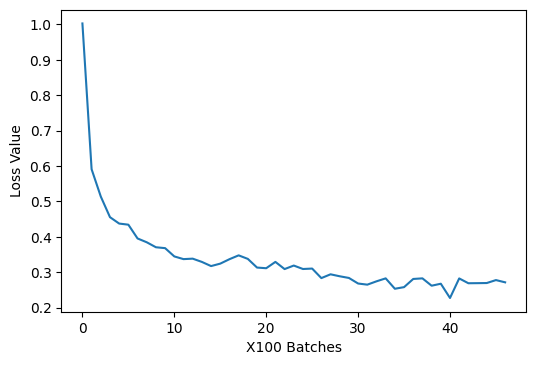

In [65]:
plt.figure(dpi=100)
plt.plot(jnp.array(losses))
plt.xlabel("X100 Batches")
plt.ylabel("Loss Value")

This confirms that we've successfully been able to train our network to produce image symbols which are more similar to their corresponding label symbols than was the case with our initial, random parameters. Below, we'll see if this is a sufficiently useful result to do classification.

# Evaluation

First, we'll load the set of Fashion-MNIST test data. These are 10,000 images of garments which were not used to train the network:

In [55]:
#load the full set of testing data to evaluate the network
x_test, y_test = tfds.as_numpy(tfds.load(dataset_name, 
                    split=['test'], 
                    data_dir="~/data",
                    shuffle_files=False,
                    as_supervised=True,
                    batch_size=-1,
                    with_info=False))[0]

To produce a class prediction from the network given a set of parameters, the symbol the network produces from an image is compared to the set of class symbols. The class symbol the image symbol is *most similar to* is chosen as the predicted label:

In [56]:
def predict(network, params, x, class_codebook = class_codebook):
    #apply the network given its parameters
    yhat = network.apply(params, x)
    #calculate similarities between the image symbols and label symbols
    similarities = similarity_outer(yhat, class_codebook)
    #return the label the image is most similar to
    classes = jnp.argmax(similarities, axis=1)

    return classes

To calculate the network's classification accuracy, we simply calculate the average rate its predicted labels match the true labels:

In [57]:
def accuracy(network, params, x, y, class_codebook = class_codebook):
    classes = predict(network, params, x, class_codebook)
    accuracy = jnp.mean(classes == y)

    return accuracy

Our accuracy on the test set is 89%, and accuracy on the original training set is slightly higher at 92%:

In [68]:
test_acc = accuracy(network, params, x_test, y_test).item()
print("Test accuracy is", test_acc)

train_acc = accuracy(network, params, images_full, labels_full)
print("Training accuracy is", train_acc)

Test accuracy is 0.8904999494552612
Training accuracy is 0.9153


In [69]:
symbols_1 = network.apply(params, images_full[0:batch_size,...])

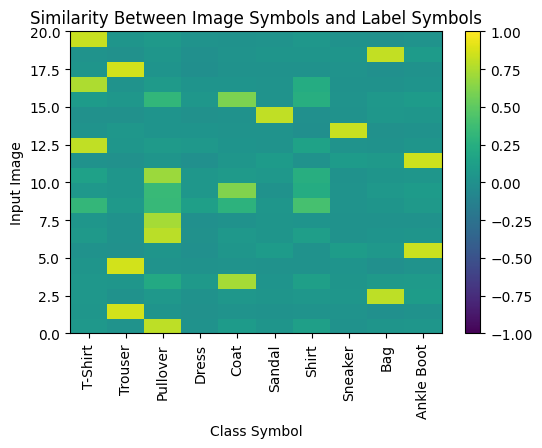

In [71]:
plot_similarity(symbols_1[0:20,...])

In [93]:
# symbolic classification